In [7]:
import numpy as np
import pandas as pd
import h5py
import scipy
import mne
import matplotlib.pyplot as plt

The following code chunk loads in the .mat file storing the dataset. Usually .mat files can be loaded in using scipy but in our case, this newer version of .mat file requires h5py as it is stored in the HDF5 format. Using the h5py package which can load in HDF5 files, the .mat file can be loaded into python. The package h5py uses HDF5 object reference objects which are references in the original file that point to an array that is created when loaded into python (#refs#). To clean the file, they must be dereferenced so that the object reference can be replaced by the numpy array that it references. This process is only neccessary for arrays containing nested 2D arrays (ie 'trial' which is an array containing 276 14x1920 arrays). The following code loads in the EEG data, label data (valence and arousal), and the Hamilton Anxiety Rating Score (HAM). It dereferences the data, transposes it, and generates a subject id array that corresponds to the other arrays. It stores the arrays of data in a dictinoary (data_dict). 

In [2]:
# Load in matlab .mat EEG dataset with h5py package
DASPS = h5py.File('DASPS+HAM labels.mat', 'r')

# Acess EEG neural recording trial data
trial_data = DASPS['Regim_datasub']['trial'][()]
trial_data = trial_data[0]
print(f"trial_data shape: {trial_data.shape}")  # Check shape
print(f"trial data[0]: {trial_data[0]}") # Check it is HDF5 object reference

# Access Labels (valence, arousal) for each trial
label_data = DASPS['Regim_datasub']['label'][()]
label_data = label_data[0]
print(f"label_data shape: {label_data.shape}")  # Check shape
print(f"label_data[0]: {label_data[0]}")  # Check it is an HDF5 object reference

# Access Hamilton Anxiety Rating Scores (HAM)
HAM = DASPS['Regim_datasub']['HAM'] 
HAM = np.array(HAM).T  # Convert to Numpy array and transpose
print(f"HAM shape: {HAM.shape}") # Check shape

# Function to dereference and extract EEG trial arrays
def access_reference(trial_ref):
    """Dereferences an HDF5 object reference and retrieves the corresponding EEG array."""

    ref_name = h5py.h5r.get_name(trial_ref, DASPS.id).decode('utf-8')  # Get reference name
    ref_key = ref_name.split('/')[-1]  # Extract the key name from the reference path
    trial_array = np.array(DASPS["#refs#"][ref_key])  # Retrieve and convert to NumPy array
    return trial_array 

# Create empty dictionary with preset dimensions
data_dict = {
    'trials': np.zeros((276, 1920, 14)),  # EEG data (14 channels, 1920 time points)
    'labels': np.zeros((276, 2)),  # Valence and Arousal (1x2)
    'HAM': np.zeros((276,)),  # Anxiety Rating (1D)
}

# Loop through all EEG trials and extract nested arrays from references
for i in range(len(trial_data)):
    ref = trial_data[i]  # Ensure you are getting the actual reference
    trial_array = access_reference(ref)  # Use reference to get array
    data_dict['trials'][i] = trial_array  # Store EEG data

# Loop through all Labels and extract nested arrays from references
for i in range(len(label_data)):
    ref = label_data[i]  # Ensure you are getting the actual reference
    label_array = access_reference(ref)  # Use reference to get array
    data_dict['labels'][i] = label_array.ravel()  # Store label data

# Add HAM 1D array to data dictionary
for i in range(len(HAM)):
    data_dict['HAM'][i] = HAM[i].item()

# Transpose all EEG data arrays and labels for ease 
data_dict['trials'] = [array.T for array in data_dict['trials']]
data_dict['labels'] = [array.T for array in data_dict['labels']]

# Add subject and scenario variables for clarity
subject_ids = [] #  Initialize the list to store subject IDs

# Add subject ID for each trial
for i in range(len(data_dict['trials'])):
    subject_id = (i // 12) + 1  # Every 12 trials, the subject changes
    subject_ids.append(subject_id)

# Convert subject_ids list to numpy array
subject_ids = np.array(subject_ids)

# Add the subject_ids to data_dict
data_dict['sub_ids'] = subject_ids


trial_data shape: (276,)
trial data[0]: <HDF5 object reference>
label_data shape: (276,)
label_data[0]: <HDF5 object reference>
HAM shape: (276, 1)


The following code chunk focuses on segmenting the cleaned EEG data into 1 second trials. This code followed an example preprocessing code in the EEG Conformer github but was written from scratch as the loading process with h5py was significantly different from scipy, which the EEG Conformer scripts uses. There are 12 trials per subject in the 'trials' array. For each subject, 6 different anxiety-inducing situations were administered verbally. The first 15 seconds of EEG data is the verbal adminsitration and the last 15 seconds of EEG data is the recall/visualization by the subject. As each of the 6 situations are divided into the two 15 second parts, this is how we get 12 trials per subject. Thus each trial represents 15 seconds and can be split into 15 seperate trials. This results in 4140 total trials across all 23 subjects. The labels and rating associated with each trials is saved in correpsonding arrays. 

In [3]:
# Segment each 15 second trial into 1 second trials

# Initialize lists
segmented_trials = []  # Store segmented EEG data
segmented_labels = []  # Store corresponding labels
segmented_HAM = []  # Store HAM ratings
segmented_sub_ids = []  # Store subject IDs for each 1-second segment

# Loop over all 276 trials
for trial_indx in range(len(data_dict['trials'])):  

    # Get data
    trial = data_dict['trials'][trial_indx]
    label = data_dict['labels'][trial_indx]  
    HAM = data_dict['HAM'][trial_indx] 
    sub_ids = data_dict['sub_ids'][trial_indx] 

    # Get number of 1-second segments (should always be 15)
    num_segments = trial.shape[1] // 128  # 1920 / 128 = 15

    # Loop through trials and segment into 128 long increments (1 second)
    for segment_indx in range(num_segments):
        segment_data = trial[ : , segment_indx * 128:(segment_indx + 1) * 128]  

        # Store segmented data
        segmented_trials.append(segment_data)
        segmented_labels.append(label)  # Store associated label
        segmented_HAM.append(HAM)  # Store associated HAM rating
        segmented_sub_ids.append(sub_ids) # Store associated subject


# Convert lists to NumPy arrays and check shape
segmented_trials = np.array(segmented_trials)  
print(segmented_trials.shape)
segmented_labels = np.array(segmented_labels)  
print(segmented_labels.shape)
segmented_HAM = np.array(segmented_HAM) 
print(segmented_HAM.shape)
segmented_sub_ids = np.array(segmented_sub_ids)  
print(segmented_sub_ids.shape)

# Store in data_dict
data_dict['segmented_trials'] = segmented_trials
data_dict['segmented_labels'] = segmented_labels
data_dict['segmented_HAM'] = segmented_HAM
data_dict['segmented_sub_ids'] = segmented_sub_ids



(4140, 14, 128)
(4140, 2)
(4140,)
(4140,)


Creating RawArray with float64 data, n_channels=14, n_times=529920
    Range : 0 ... 529919 =      0.000 ...  4139.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 s)



/tmp/ipykernel_228/625386937.py:47: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 18.5s.


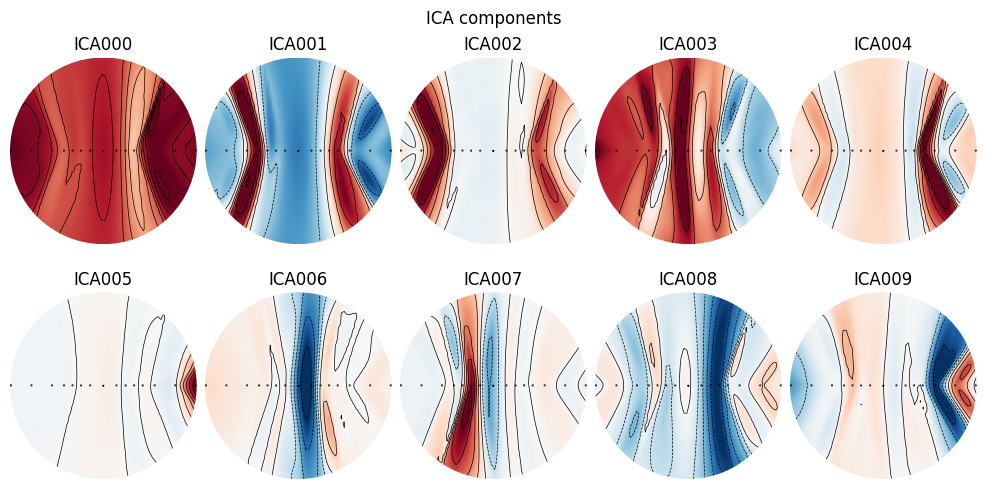

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components


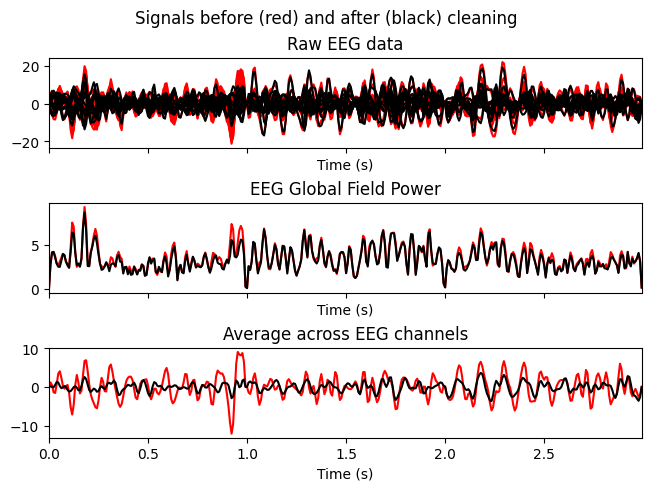

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
2070 matching events found
No baseline correction applied
0 projection items activated


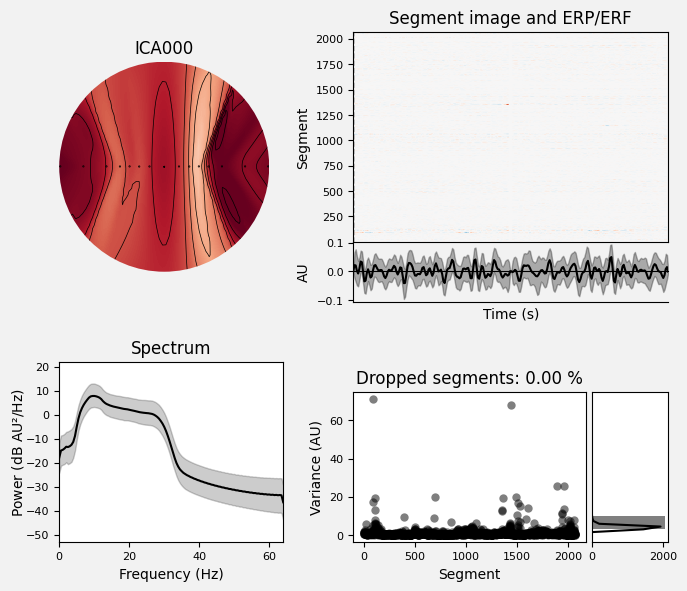

Creating RawArray with float64 data, n_channels=10, n_times=529920
    Range : 0 ... 529919 =      0.000 ...  4139.992 secs
Ready.
Using matplotlib as 2D backend.


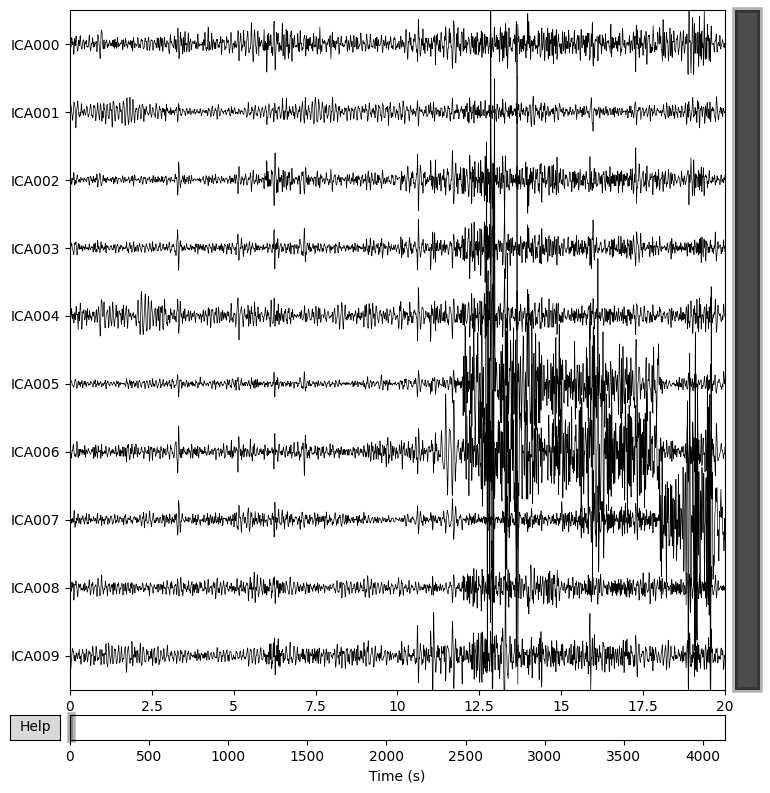

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components
(14, 529920)
(14, 4140, 128)
(4140, 14, 128)


In [11]:
# Band pass filter and artifact removal
sfreq = 128

# Apply 4-40 Hz bandpass filter 
Wl, Wh = 4, 40
Wn = [Wl * 2 / sfreq, Wh * 2 / sfreq]  # Normalized cutoff
b, a = scipy.signal.cheby2(6, 60, Wn, btype='bandpass')

# Apply filter to all trials
# Need to transpose data to apply filtfilt but tranpose back after 
filtered_segmented_trials = np.zeros((4140, 14, 128))

for i in range(segmented_trials.shape[0]):
    filtered_segmented_trials[i, :, :] = scipy.signal.filtfilt(
        b, a, segmented_trials[i, :, :].T, axis=0).T
    
# ICA HERE

# Define electrode names (Emotiv EPOC)
ch_pos = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", 
      "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]

coords = 'coordinates.locs'

# Read the data from the file
data = np.loadtxt(coords, dtype=str)

# Extract the coordinates (2nd and 3rd columns)
x_coords = data[:, 1].astype(float)
y_coords = data[:, 2].astype(float)
z_coords = np.zeros_like(x_coords)  # Sets z coords to 0 (don't have any for 2D)

# Create a dictionary mapping the channel names to the coordinates
ch_pos_dict = {ch_name: (x, y, z) for ch_name, x, y, z in zip(ch_pos, x_coords, y_coords, z_coords)}

# Create the custom montage
montage = mne.channels.make_dig_montage(ch_pos=ch_pos_dict)

info = mne.create_info(ch_names=montage.ch_names, sfreq=128.,
                        ch_types='eeg')

# Convert the data array to the shape (channels, time) for RawArray
data_array_raw = filtered_segmented_trials.transpose(1, 0, 2).reshape(14, -1)  # (channels, trials * time)

# Create a RawArray
raw = mne.io.RawArray(data_array_raw, info)
raw.set_montage(montage)

raw = raw.filter(l_freq=1.0, h_freq=None)

# Use ICA for component extraction
ica = mne.preprocessing.ICA(n_components=10, random_state=97, max_iter=800)
ica.fit(raw) 

# Visualize the ICA components
ica.plot_components(outlines='head')
raw.load_data()
ica.plot_overlay(raw, exclude=[0], picks="eeg")
ica.plot_properties(raw, picks=[0])  # Shows time series and frequency content
ica.plot_sources(raw)


# Exclude Comp 0 based on plots
ica.exclude = [0] 

# Apply ICA to raw data to remove the excluded component(s)
raw_cleaned = ica.apply(raw)

# Get the data from the epochs object
data_array_cleaned = raw_cleaned.get_data()  # This will return an array of shape (epochs, channels, time)
print(data_array_cleaned.shape)
# Reshape back to (trials, channels, epochs)
data_restored = data_array_cleaned.reshape(4140, 14, 128)
data_restored = data_restored.transpose(1, 0, 2)
print(data_restored.shape)
# Transpose
filtered_segmented_trials = data_restored.transpose(1, 0, 2)  
print(filtered_segmented_trials.shape)


# Store in data_dict
data_dict['filtered_segmented_trials'] = filtered_segmented_trials

The following code seperates the label data (valence and arousal) into four categories based on the published paper on the DASPS dataset. They defined anxiety as low valence, high arousal. The code impliments their description of how they categorized the anxiety states. 

In [4]:
# # Categorization function (FOUR STATES)
# def categorize_anxiety(valence, arousal):
#     """ Categorizes anxiety state in DASPS label data based on valence and arousal as described by Baghdadi et al. """

#     if valence >= 0 and valence <= 2 and arousal >= 7 and arousal <= 9:
#         return 'Severe Anxiety'
#     elif valence >= 2 and valence <= 4 and arousal >= 6 and arousal <= 7:
#         return 'Moderate Anxiety'
#     elif valence >= 4 and valence <= 5 and arousal >= 5 and arousal <= 6:
#         return 'Light Anxiety'
#     else:
#         return 'Normal Anxiety'

# # Runs categorization for 267 15 seconds trials
# anxiety_cat = []
# for valence, arousal in data_dict['labels']:
#     anxiety_cat.append(categorize_anxiety(valence, arousal))


# print(f"Categories for 267 trials:\n {pd.DataFrame(anxiety_cat).value_counts()}")

# # Runs categorization for 4140 1 second trials
# anxiety_cat_segmented = []
# for valence, arousal in data_dict['segmented_labels']:
#     anxiety_cat_segmented.append(categorize_anxiety(valence, arousal))


# print(f"\nCategories for 4140 trials:\n {pd.DataFrame(anxiety_cat_segmented).value_counts()}")

# data_dict['anxiety_cat_segmented'] = anxiety_cat_segmented

# # Convert to integer labels

# # Define the mapping of string labels to integers
# label_map = {
#     "Normal Anxiety": 0,
#     "Light Anxiety": 1,
#     "Moderate Anxiety": 2,
#     "Severe Anxiety": 3
# }

# # Convert string labels to integers using the mapping
# anxiety_states = np.array([label_map[label] for label in anxiety_cat_segmented])

# data_dict['anxiety_states'] = anxiety_states

# print(f"\nCategories for Numeric Labels:\n {pd.DataFrame(anxiety_states).value_counts()}")

In [5]:
# Categorization function (TWO STATES)
def categorize_anxiety(valence, arousal):
    """ Categorizes anxiety state in DASPS label data 
    based on valence and arousal as described by Baghdadi et al. """

    if valence < 5 and arousal > 5:
        return 'Anxiety'
    else:
        return 'No Anxiety'

# Runs categorization for 267 15 seconds trials
anxiety_cat = []
for valence, arousal in data_dict['labels']:
    anxiety_cat.append(categorize_anxiety(valence, arousal))


print(f"Categories for 267 trials:\n {pd.DataFrame(anxiety_cat).value_counts()}")

# Runs categorization for 4140 1 second trials
anxiety_cat_segmented = []
for valence, arousal in data_dict['segmented_labels']:
    anxiety_cat_segmented.append(categorize_anxiety(valence, arousal))


print(f"\nCategories for 4140 trials:\n {pd.DataFrame(anxiety_cat_segmented).value_counts()}")

data_dict['anxiety_cat_segmented'] = anxiety_cat_segmented

# Convert to integer labels

# Define the mapping of string labels to integers
label_map = {
    "No Anxiety": 0,
    "Anxiety": 1
}

# Convert string labels to integers using the mapping
anxiety_states = np.array([label_map[label] for label in anxiety_cat_segmented])

data_dict['anxiety_states'] = anxiety_states

print(f"\nCategories for Numeric Labels:\n {pd.DataFrame(anxiety_states).value_counts()}")

Categories for 267 trials:
 No Anxiety    142
Anxiety       134
dtype: int64

Categories for 4140 trials:
 No Anxiety    2130
Anxiety       2010
dtype: int64

Categories for Numeric Labels:
 0    2130
1    2010
dtype: int64


In [100]:
# Initialize a dictionary to hold the trials and labels for each subject
subject_dict = {}

# Loop through each subject ID
for sub_id in set(data_dict['segmented_sub_ids']): 
    # Get the indices for this subject
    subject_indices = [i for i, x in enumerate(data_dict['segmented_sub_ids']) if x == sub_id]
    
    # Extract the trials and labels for this subject using the indices
    subject_trials = data_dict['filtered_segmented_trials'][subject_indices] 
    subject_labels = [data_dict['anxiety_states'][i] for i in subject_indices]
    
    # Store the trials and labels in the dictionary
    subject_dict[sub_id] = {'trials': subject_trials, 'labels': subject_labels}

for sub in subject_dict:
    
    counts = np.bincount(subject_dict[sub]['labels'])
    print(f"Sub {sub} has {counts[0]} No Axiety (0) trials")
    
    try:
        print(f"Sub {sub} has {counts[1]} Anxiety (1) trials")
    except:
        print(f"Sub {sub} has no Anxiety trials")
    
    print("\n")
    
    



Sub 1 has 30 No Axiety (0) trials
Sub 1 has 150 Anxiety (1) trials


Sub 2 has 150 No Axiety (0) trials
Sub 2 has 30 Anxiety (1) trials


Sub 3 has 150 No Axiety (0) trials
Sub 3 has 30 Anxiety (1) trials


Sub 4 has 60 No Axiety (0) trials
Sub 4 has 120 Anxiety (1) trials


Sub 5 has 30 No Axiety (0) trials
Sub 5 has 150 Anxiety (1) trials


Sub 6 has 90 No Axiety (0) trials
Sub 6 has 90 Anxiety (1) trials


Sub 7 has 90 No Axiety (0) trials
Sub 7 has 90 Anxiety (1) trials


Sub 8 has 90 No Axiety (0) trials
Sub 8 has 90 Anxiety (1) trials


Sub 9 has 60 No Axiety (0) trials
Sub 9 has 120 Anxiety (1) trials


Sub 10 has 180 No Axiety (0) trials
Sub 10 has no Anxiety trials


Sub 11 has 120 No Axiety (0) trials
Sub 11 has 60 Anxiety (1) trials


Sub 12 has 90 No Axiety (0) trials
Sub 12 has 90 Anxiety (1) trials


Sub 13 has 120 No Axiety (0) trials
Sub 13 has 60 Anxiety (1) trials


Sub 14 has 150 No Axiety (0) trials
Sub 14 has 30 Anxiety (1) trials


Sub 15 has 150 No Axiety (0) tri

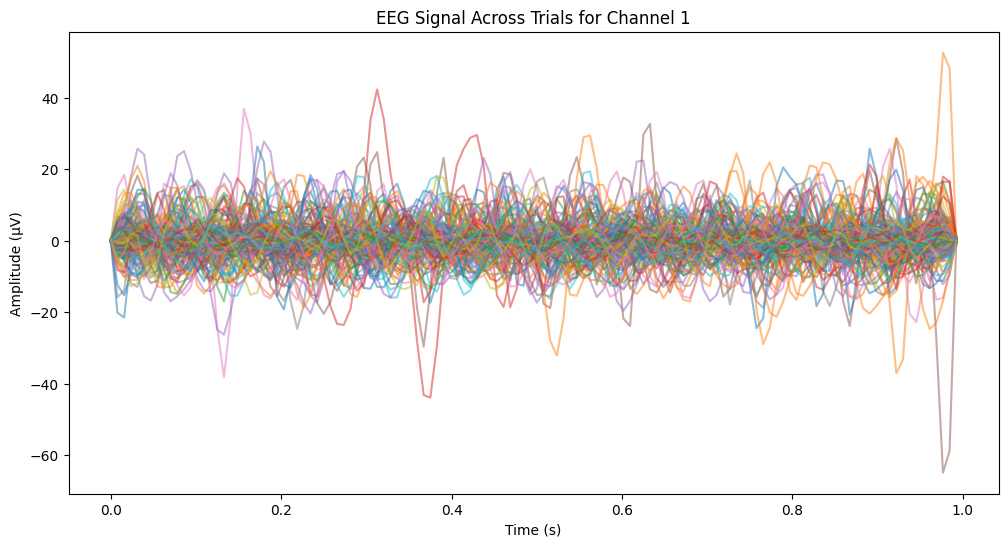

In [102]:
# Plot raw EEG data

def plot_trials_one_subject(eeg_trials, sfreq, channel_idx=0):
    """
    Plot raw EEG signal across multiple trials for a single subject.
    
    eeg_trials: np.array of shape (n_trials, n_channels, n_samples)
    sfreq: Sampling frequency in Hz
    channel_idx: Index of the channel to visualize
    """
    plt.figure(figsize=(12, 6))
    time = np.arange(eeg_trials.shape[2]) / sfreq

    for trial in range(eeg_trials.shape[0]):
        plt.plot(time, eeg_trials[trial, channel_idx], alpha=0.5, label=f'Trial {trial+1}')

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"EEG Signal Across Trials for Channel {channel_idx}")
    plt.show()


sfreq = 128 
eeg_trials = subject_dict[1]['trials']
eeg_trials.shape

plot_trials_one_subject(eeg_trials, sfreq, channel_idx=1)



/home/lcrankshaw/.local/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  warnings.warn('nperseg = {0:d} is greater than input length '


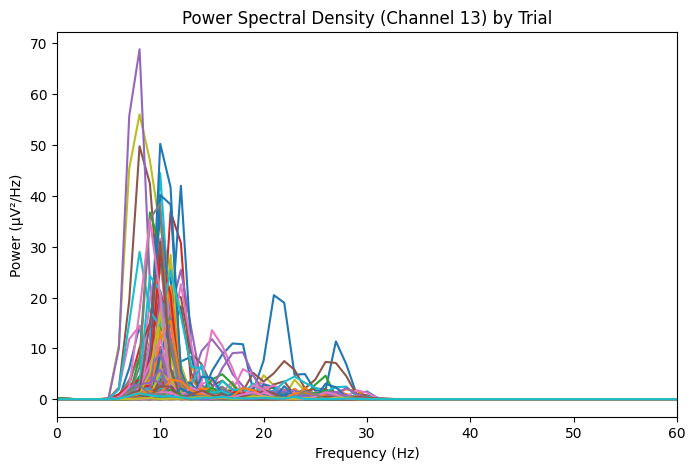

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_psd_by_trial(eeg_data, sfreq, channel_idx=0):
    """
    Plots the power spectral density (PSD) of EEG data across multiple trials.
    
    eeg_data: np.array of shape (n_trials, n_channels, n_samples)
    sfreq: Sampling frequency in Hz
    channel_idx: Channel index to analyze
    """
    n_trials = eeg_data.shape[0] 

    plt.figure(figsize=(8, 5))

    for trial in range(n_trials):
        f, psd = welch(eeg_data[trial, channel_idx], sfreq, nperseg=sfreq*2)
        plt.plot(f, psd, label=f'Trial {trial+1}')

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power (µV²/Hz)")
    plt.title(f"Power Spectral Density (Channel {channel_idx}) by Trial")
    plt.xlim([0, 60])  # Focus on relevant EEG frequencies
    plt.show()


sfreq = 128  # Sampling frequency
eeg_data = subject_dict[1]['trials']

plot_psd_by_trial(eeg_data, sfreq, channel_idx=13)



The following code is adapted from the EEG conformer script 'conformer_seed_1s_5fold.py'. Significant adaptations were required for the data loading and processing as this script used scipy which was not possible for this experiment's .mat files. Instead, this script was adapted to directly load the previously cleaned data from the data_dict. The DASPS dataset used for this project formated all trials for all subjects into one file while the dataset used in the example code required individual subject files be loaded in. Thus changes to the processing were made. Other alterations included changes to some of the neural network parameters due to different numbers in EEG channels and number of time points for each trial. 'EDIT:' in the following code is used to indicate which changes were made to accomodate this project's data. 

In [105]:
"""
EEG conformer 

Test SEED data 1 second
perform strict 5-fold cross validation 
"""


import argparse
import os
gpus = [1] 
#os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
#os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(map(str, gpus))
import numpy as np
import math
import glob
import random
import itertools
import datetime
import time
import datetime
import sys
import scipy.io

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchsummary import summary
import torch.autograd as autograd
from torchvision.models import vgg19

import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn.init as init

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from sklearn.decomposition import PCA

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

import accelerate
import transformers

import matplotlib.pyplot as plt
import mne
# from torch.utils.tensorboard import SummaryWriter
from torch.backends import cudnn
from utils import GradCAM, show_cam_on_image
cudnn.benchmark = False
cudnn.deterministic = True
print(torch.cuda.is_available())

class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):  # EDIT: emb_size = 80 instead of emb_size = 40
        super().__init__()

        self.eegnet = nn.Sequential(
            nn.Conv2d(1, 8, (1, 128), (1, 1)),  # EDIT: (1, 125) to (1, 128)
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, (14, 1), (1, 1)),  # EDIT: (22, 1) to (14, 1)
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.AvgPool2d((1, 4), (1, 4)),
            nn.Dropout(0.5),
            nn.Conv2d(16, 16, (1, 16), (1, 1)),
            nn.BatchNorm2d(16), 
            nn.ELU(),
            nn.AvgPool2d((1, 8), (1, 8)),
            nn.Dropout2d(0.5)
        )

        self.shallownet = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.Conv2d(40, 40, (14, 1), (1, 1)),  # EDIT: (62,1) to (14,1)
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.AvgPool2d((1, 75), (1, 15)),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  # 5 is better than 1
            Rearrange('b e (h) (w) -> b (h w) e'),
        )


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape

        x = self.shallownet(x)
        x = self.projection(x)
        
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return input*0.5*(1.0+torch.erf(input/math.sqrt(2.0)))

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=5,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class TransformerEncoder(nn.Sequential):
    def __init__(self, depth, emb_size):
        super().__init__(*[TransformerEncoderBlock(emb_size) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, n_classes):
        super().__init__()
        self.cov = nn.Sequential(
            nn.Conv1d(190, 1, 1, 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5)
        )
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )
        self.clshead_fc = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, 32),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(32, n_classes)
        )
        self.fc = nn.Sequential(
            nn.Linear(80, 32),  # EDIT: 280 to 80
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(32, n_classes)  # EDIT: 3 to n_classes 
        )

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        out = self.fc(x)

        return x, out


# ! Rethink the use of Transformer for EEG signal
class ViT(nn.Sequential):
    def __init__(self, emb_size=40, depth=6, n_classes=2, **kwargs):
        super().__init__(

            PatchEmbedding(emb_size),
            TransformerEncoder(depth, emb_size),
            ClassificationHead(emb_size, n_classes)
        )


class ExGAN():
    def __init__(self, nsub, fold):
        super(ExGAN, self).__init__()
        self.batch_size = 200
        self.n_epochs = 600  #1000
        self.img_height = 14 # EDIT: 22 to 14 (channels)
        self.img_width = 128 # EDIT: 600 to 128 (epochs)
        self.channels = 1
        self.c_dim = 4
        self.lr = 0.0002 
        self.b1 = 0.5
        self.b2 = 0.999
        self.alpha = 0.0002
        self.dimension = (190, 50) #  EDIT: might need to change
        self.nSub = nsub

        self.start_epoch = 0
        #self.root = '/Data/SEED/seed_syh/data_cv5fold/'  # EDIT: no need for root path

        self.pretrain = False

        # EDIT: change file path
        #self.log_write = open("log_subject%d_fold%d.txt" % (self.nSub, fold+1), "w")

        self.img_shape = (self.channels, self.img_height, self.img_width)

        self.Tensor = torch.cuda.FloatTensor
        self.LongTensor = torch.cuda.LongTensor

        self.criterion_l1 = torch.nn.L1Loss().cuda()
        self.criterion_l2 = torch.nn.MSELoss().cuda()
        self.criterion_cls = torch.nn.CrossEntropyLoss().cuda()

        self.model = ViT().cuda()
        self.model = nn.DataParallel(self.model, device_ids=[i for i in range(len(gpus))])
        self.model = self.model.cuda()

        self.centers = {}

    def interaug(self, timg, label):
        aug_data = []
        aug_label = []
        for cls4aug in range(4):
            cls_idx = np.where(label == cls4aug)
            print(f"cls_idx: {cls_idx}")
            tmp_data = timg[cls_idx]
            print(f"tmp_data: {tmp_data.shape}")
            tmp_label = label[cls_idx]
            print(f"tmp_label: {tmp_label}")

            tmp_aug_data = np.zeros((int(self.batch_size / 4), 1, 14, 128))
            for ri in range(int(self.batch_size / 4)):
                for rj in range(8):
                    rand_idx = np.random.randint(0, tmp_data.shape[0], 8)
                    tmp_aug_data[ri, :, :, rj * 16:(rj + 1) * 16] = tmp_data[rand_idx[rj], :, :,
                                                                      rj * 16:(rj + 1) * 16]

            aug_data.append(tmp_aug_data)
            aug_label.append(tmp_label[:int(self.batch_size / 3)])
        print(aug_data)
        print(aug_label)
        aug_data = np.concatenate(aug_data)
        aug_label = np.concatenate(aug_label)
        print(aug_data)
        print(aug_label)
        aug_shuffle = np.random.permutation(len(aug_data))
        aug_data = aug_data[aug_shuffle, :, :]
        aug_label = aug_label[aug_shuffle]

        aug_data = torch.from_numpy(aug_data).cuda() 
        aug_data = aug_data.float()
        aug_label = torch.from_numpy(aug_label).cuda()
        aug_label = aug_label.long()
        return aug_data, aug_label

    # EDIT: changed significant portions of this function
    def get_source_data(self, fold):

        self.all_data = subject_dict[self.nSub]['trials']   # EDIT: load in EEG data from subject_dict
        self.all_label = subject_dict[self.nSub]['labels']  # EDIT: load in anxiety states from subject_dict
        self.train_data = []
        self.train_label = []
        self.test_data = []
        self.test_label = []

        # for tri in range(np.shape(self.all_data)[0]):  # EDIT: remove for loop
        tmp_tri = np.array(self.all_data)  # EDIT: remove [tri]
        tmp_tri_label = np.array(self.all_label)   # EDIT: remove [tri]

        one_fold_num = np.shape(tmp_tri)[0] // 5  
        tri_num =  one_fold_num * 5
        tmp_tri_idx = np.arange(tri_num)
        test_idx = np.arange(one_fold_num * fold, one_fold_num * (fold+1))
        train_idx = np.delete(tmp_tri_idx, test_idx)

        self.train_data.append(tmp_tri[train_idx])  
        self.train_label.append(tmp_tri_label[train_idx])  
        self.test_data.append(tmp_tri[test_idx])  
        self.test_label.append(tmp_tri_label[test_idx])  

        self.train_data = np.concatenate(self.train_data)
        self.train_data = np.expand_dims(self.train_data, axis=1)
        self.train_label = np.concatenate(self.train_label)  
        self.test_data = np.concatenate(self.test_data)
        self.test_data = np.expand_dims(self.test_data, axis=1)
        self.test_label = np.concatenate(self.test_label) 

        shuffle_num = np.random.permutation(len(self.train_data))
        self.train_data = self.train_data[shuffle_num, :, :, :]
        self.train_label = self.train_label[shuffle_num]

        # standardize
        # target_mean = np.mean(self.train_data)
        # target_std = np.std(self.train_data)
        # self.train_data = (self.train_data - target_mean) / target_std
        # self.test_data = (self.test_data - target_mean) / target_std

        #print(self.train_data.shape)

        return self.train_data, self.train_label, self.test_data, self.test_label

    def update_lr(self, optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    def aug(self, img, label):
        aug_data = []
        aug_label = []
        for cls4aug in range(4):
            cls_idx = np.where(label == cls4aug)  # EDIT: remove cls4aug + 1 (classes start at 0)
            tmp_data = img[cls_idx]
            tmp_label = label[cls_idx]

            tmp_aug_data = np.zeros(tmp_data.shape)
            for ri in range(tmp_data.shape[0]):
                for rj in range(8):
                    rand_idx = np.random.randint(0, tmp_data.shape[0], 8)
                    tmp_aug_data[
                        ri, :, :, rj * 128:(rj + 1) * 128] = tmp_data[
                            rand_idx[rj], :, :, rj * 128:(rj + 1) * 128]  # EDIT: change all 125 to 128

            aug_data.append(tmp_aug_data)
            aug_label.append(tmp_label)
        aug_data = np.concatenate(aug_data)
        aug_label = np.concatenate(aug_label)
        aug_shuffle = np.random.permutation(len(aug_data))
        aug_data = aug_data[aug_shuffle, :, :]
        aug_label = aug_label[aug_shuffle]

        return aug_data, aug_label

    def update_centers(self, feature, label):
            deltac = {}
            count = {}
            count[0] = 0
            for i in range(len(label)):
                l = label[i]
                if l in deltac:
                    deltac[l] += self.centers[l]-feature[i]
                else:
                    deltac[l] = self.centers[l]-feature[i]
                if l in count:
                    count[l] += 1
                else:
                    count[l] = 1

            for ke in deltac.keys():
                deltac[ke] = deltac[ke]/(count[ke]+1)

            return deltac

    def train(self, fold):
        
        img, label, test_data, test_label = self.get_source_data(fold)

        img = torch.from_numpy(img)
        label = torch.from_numpy(label)  # EDIT: remove label + 1

        dataset = torch.utils.data.TensorDataset(img, label)
        self.dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)

        test_data = torch.from_numpy(test_data)
        test_label = torch.from_numpy(test_label)  #  EDIT: remove test_label + 1
        test_dataset = torch.utils.data.TensorDataset(test_data, test_label)
        self.test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=self.batch_size, shuffle=True)

        for i in range(self.c_dim):
            self.centers[i] = torch.randn(self.dimension)
            self.centers[i] = self.centers[i].cuda()

        # Optimizers
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(self.b1, self.b2))

        test_data = Variable(test_data.type(self.Tensor))
        test_label = Variable(test_label.type(self.LongTensor))

        bestAcc = 0
        averAcc = 0
        num = 0
        Y_true = 0
        Y_pred = 0

        # Train the cnn model
        total_step = len(self.dataloader)
        curr_lr = self.lr

        for e in range(self.n_epochs):
            in_epoch = time.time()
            self.model.train()
            for i, (img, label) in enumerate(self.dataloader):

                img =  Variable(img.cuda().type(self.Tensor)) 
                # img = self.active_function(img)
                label = Variable(label.cuda().type(self.LongTensor))

                # # EDIT: add call to interaug
                # aug_data, aug_label = self.interaug(self.train_data, self.train_label)
                # img = torch.cat((img, aug_data))
                # label = torch.cat((label, aug_label))

                tok, outputs = self.model(img)

                # Central loss
                cen_feature = tok
                cen_label = label
                nplabela = cen_label.cpu().numpy()

                # EDIT
                # training_args = TrainingArguments(output_dir="test_trainer", no_cuda=True)


                loss = self.criterion_cls(outputs, label)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            out_epoch = time.time()

            if (e + 1) % 1 == 0:
                self.model.eval()
                Tok, Cls = self.model(test_data)

                loss_test = self.criterion_cls(Cls, test_label)
                y_pred = torch.max(Cls, 1)[1]
                acc = float((y_pred == test_label).cpu().numpy().astype(int).sum()) / float(test_label.size(0))
                train_pred = torch.max(outputs, 1)[1]
                train_acc = float((train_pred == label).cpu().numpy().astype(int).sum()) / float(label.size(0))
                # print('The epoch is:', e, '  The accuracy is:', acc)
                # print('Epoch:', e,
                #       '  Train loss: %.4f' % loss.detach().cpu().numpy(),
                #       '  Test loss: %.4f' % loss_test.detach().cpu().numpy(),
                #       '  Train acc: %.4f' % train_acc,
                #       '  Test acc: %.4f' % acc)
                #self.log_write.write(str(e) + "    " + str(acc) + "\n")
                num = num + 1
                averAcc = averAcc + acc
                if acc > bestAcc:
                    bestAcc = acc
                    Y_true = test_label
                    Y_pred = y_pred

        torch.save(self.model.module.state_dict(), f'model_subject{self.nSub}.pth')
        averAcc = averAcc / num
        print('The average accuracy of fold%d is:' %(fold+1), averAcc)
        print('The best accuracy of fold%d is:' %(fold+1), bestAcc)
        #self.log_write.write('The average accuracy of fold%d is: ' %(fold+1) + str(averAcc) + "\n")
        #self.log_write.write('The best accuracy fold%d is: ' %(fold+1) + str(bestAcc) + "\n")
        return bestAcc, averAcc, Y_true, Y_pred
        # writer.close()

def main():
    best = 0
    aver = 0
    result_write = open("sub_result.txt", "w")

    for i in range(23):
        starttime = datetime.datetime.now()
        seed_n = np.random.randint(2021)

        result_write.write('--------------------------------------------------')
        print('seed is ' + str(seed_n))
        random.seed(seed_n)
        np.random.seed(seed_n)
        torch.cuda.manual_seed(seed_n)
        torch.cuda.manual_seed_all(seed_n)
        print('Subject %d' % (i+1))
        
        result_write.write('Subject ' + str(i + 1) + ' : ' + 'Seed is: ' + str(seed_n) + "\n")

        ba = 0
        aa = 0
        bestAcc = 0
        averAcc = 0

        for fold in range(5):
            exgan = ExGAN(i + 1, fold)
            ba, aa, _, _ = exgan.train(fold)
            # print('THE BEST ACCURACY IS ' + str(ba))
            result_write.write('Best acc of fold' + str(fold+1) + 'is: ' + str(ba) + "\n")
            result_write.write('Aver acc of fold' + str(fold+1) + 'is: ' + str(aa) + "\n")
            bestAcc += ba
            averAcc += aa

        bestAcc /= 5
        averAcc /= 5
        result_write.write('5-fold Best acc is: ' + str(bestAcc) + "\n")
        result_write.write('5-fold Aver acc is: ' + str(averAcc) + "\n")
        #plot_confusion_matrix(Y_true, Y_pred, i+1)
        best = best + bestAcc
        aver = aver + averAcc
        endtime = datetime.datetime.now()
        print('subject %d duration: '%(i+1) + str(endtime - starttime))


    best = best / 23  # EDIT: 15 to 23 subs
    aver = aver / 23

    result_write.write('--------------------------------------------------')
    result_write.write('All subject Best accuracy is: ' + str(best) + "\n")
    result_write.write('All subject Aver accuracy is: ' + str(aver) + "\n")
    result_write.close()


if __name__ == "__main__":
    print(time.asctime(time.localtime(time.time())))
    main()
    print(time.asctime(time.localtime(time.time())))

True


Pre-normalization mean: 0.00013314584592737176
Pre-normalization std: 3.779607724754065
Post-normalization mean: 1.0284432036148214e-17
Post-normalization std: 1.0
MEAN mean: 8.673617379884035e-18
MEAN std: 0.016382775232515648


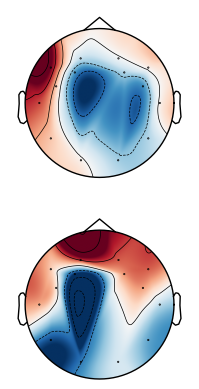

Pre-normalization mean: 0.0002982410703781002
Pre-normalization std: 5.518222192026553
Post-normalization mean: 4.212899870229388e-18
Post-normalization std: 1.0
MEAN mean: 6.938893903907228e-18
MEAN std: 0.023767973484591805


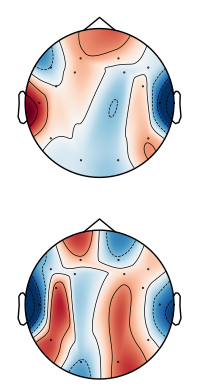

Pre-normalization mean: 0.0005048903433072417
Pre-normalization std: 6.274642773951358
Post-normalization mean: 1.1895246692412391e-17
Post-normalization std: 0.9999999999999999
MEAN mean: 1.0903976134711359e-17
MEAN std: 0.017028341118705714


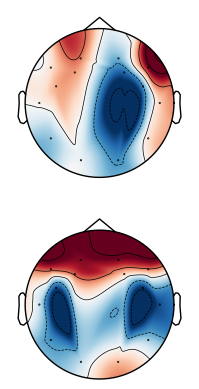

Pre-normalization mean: -1.4001870223469794e-05
Pre-normalization std: 3.56169343841879
Post-normalization mean: 2.1064499351146942e-17
Post-normalization std: 1.0
MEAN mean: 1.883414059631962e-17
MEAN std: 0.022739394598948214


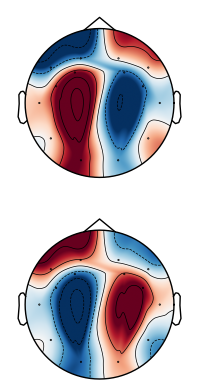

Pre-normalization mean: -0.0005110988046201994
Pre-normalization std: 5.484901620373968
Post-normalization mean: 3.469446951953614e-18
Post-normalization std: 1.0
MEAN mean: -2.4781763942525814e-19
MEAN std: 0.02122842447668424


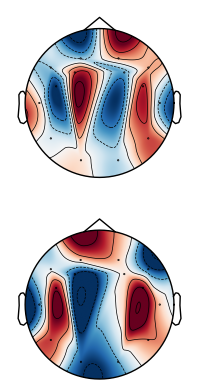

Pre-normalization mean: -8.513292278864523e-05
Pre-normalization std: 3.6545540349977506
Post-normalization mean: 3.122502256758253e-17
Post-normalization std: 1.0
MEAN mean: 3.345538132240985e-17
MEAN std: 0.016308334850298933


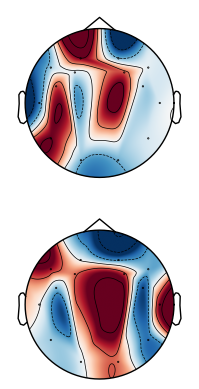

Pre-normalization mean: -0.00013226804677271762
Pre-normalization std: 3.5995128622361316
Post-normalization mean: 6.071532165918825e-18
Post-normalization std: 1.0
MEAN mean: 1.4869058365515489e-18
MEAN std: 0.02210930686813318


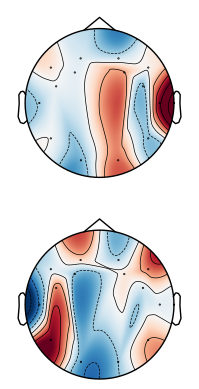

Pre-normalization mean: -0.0002134536463488816
Pre-normalization std: 3.8413303346941503
Post-normalization mean: -2.9738116731030977e-18
Post-normalization std: 1.0
MEAN mean: -1.2390881971262908e-18
MEAN std: 0.015747472803699564


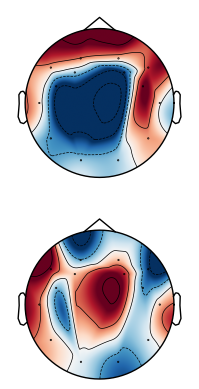

Pre-normalization mean: -0.00010020135422000441
Pre-normalization std: 3.3798710109081203
Post-normalization mean: 2.1807952269422717e-17
Post-normalization std: 1.0
MEAN mean: 2.1064499351146942e-17
MEAN std: 0.01678679289706689


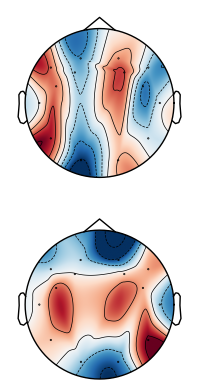

Pre-normalization mean: 0.0005057453072157246
Pre-normalization std: 4.6155704158322015
Post-normalization mean: 2.3790493384824782e-17
Post-normalization std: 0.9999999999999999
MEAN mean: 2.279922282712375e-17
MEAN std: 0.016911869720143073


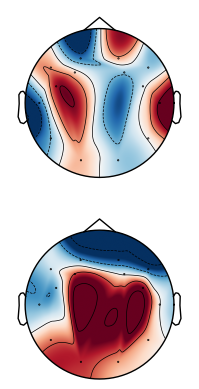

Pre-normalization mean: 3.926364844032902e-05
Pre-normalization std: 9.116723458332306
Post-normalization mean: -1.1895246692412391e-17
Post-normalization std: 1.0
MEAN mean: -1.1399611413561875e-17
MEAN std: 0.016915861192002828


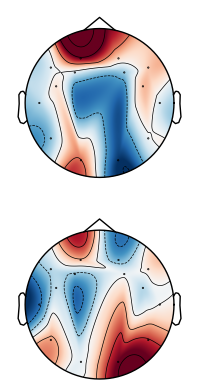

Pre-normalization mean: -0.00021917025005016634
Pre-normalization std: 9.34559927990453
Post-normalization mean: -1.0160523216435584e-17
Post-normalization std: 1.0
MEAN mean: -8.921435019309294e-18
MEAN std: 0.027849661623735377


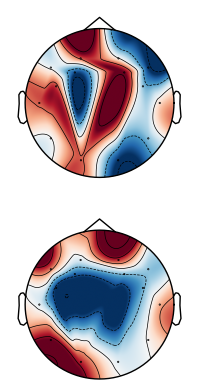

Pre-normalization mean: 0.00014594309719631032
Pre-normalization std: 4.079052614438212
Post-normalization mean: -1.734723475976807e-17
Post-normalization std: 1.0
MEAN mean: -1.5364693644366007e-17
MEAN std: 0.013775688971541253


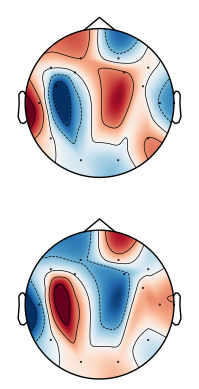

Pre-normalization mean: 0.00013557370391860865
Pre-normalization std: 5.700527915402358
Post-normalization mean: 7.434529182757744e-19
Post-normalization std: 0.9999999999999999
MEAN mean: 2.2303587548273236e-18
MEAN std: 0.012610349143461345


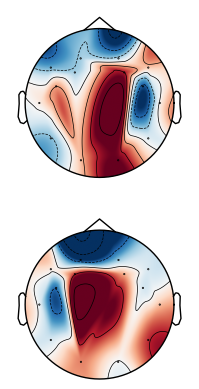

Pre-normalization mean: 0.0001464830568548024
Pre-normalization std: 6.341294179493468
Post-normalization mean: 6.195440985631454e-19
Post-normalization std: 0.9999999999999999
MEAN mean: -5.204170427930421e-18
MEAN std: 0.013503953097776052


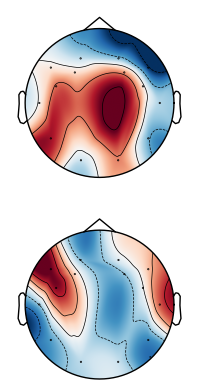

Pre-normalization mean: 8.982936499097182e-05
Pre-normalization std: 6.253182769418523
Post-normalization mean: 1.5364693644366007e-17
Post-normalization std: 1.0
MEAN mean: 1.623205538235441e-17
MEAN std: 0.019743681324803787


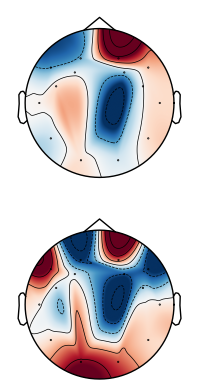

Pre-normalization mean: 0.00020879624937776488
Pre-normalization std: 4.561456422096702
Post-normalization mean: 1.883414059631962e-17
Post-normalization std: 1.0
MEAN mean: 1.734723475976807e-17
MEAN std: 0.019053396857602496


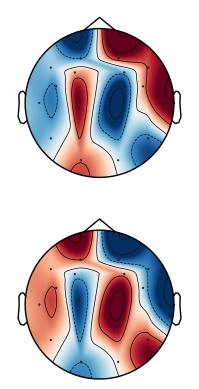

Pre-normalization mean: -4.681866716825247e-05
Pre-normalization std: 5.867321395306696
Post-normalization mean: -1.2390881971262908e-18
Post-normalization std: 1.0
MEAN mean: -6.195440985631454e-19
MEAN std: 0.013034035005674039


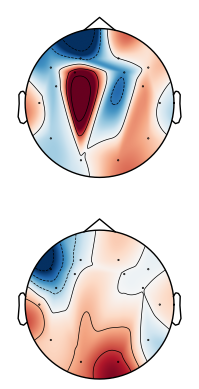

Pre-normalization mean: -2.3667788386150392e-05
Pre-normalization std: 3.207661247212388
Post-normalization mean: -1.4869058365515489e-18
Post-normalization std: 1.0
MEAN mean: -3.221629312528356e-18
MEAN std: 0.01352584079333158


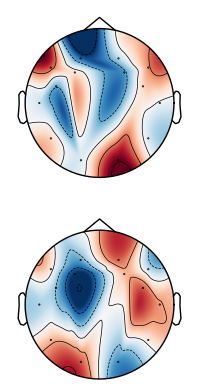

Pre-normalization mean: 6.990747877011453e-05
Pre-normalization std: 5.3697398253026405
Post-normalization mean: -2.1312316990572203e-17
Post-normalization std: 1.0
MEAN mean: -2.577303450022685e-17
MEAN std: 0.016708671560746808


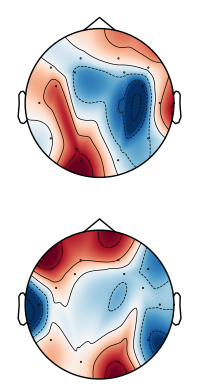

Pre-normalization mean: -8.165104434684993e-05
Pre-normalization std: 6.668578967840698
Post-normalization mean: 4.584626329367276e-18
Post-normalization std: 1.0
MEAN mean: 2.4781763942525816e-18
MEAN std: 0.018903422742115393


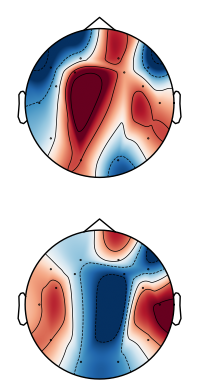

Pre-normalization mean: 0.00023147084521967531
Pre-normalization std: 7.97274847029702
Post-normalization mean: 2.825121089447943e-17
Post-normalization std: 1.0
MEAN mean: 3.0481569649306756e-17
MEAN std: 0.023141896616315605


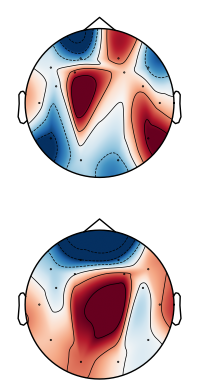

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4fef88d490>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Pre-normalization mean: 0.00010077027705631182
Pre-normalization std: 6.823206985391263
Post-normalization mean: -1.2266973151550278e-17
Post-normalization std: 0.9999999999999999
MEAN mean: -1.3072380479682368e-17
MEAN std: 0.02953654256392697


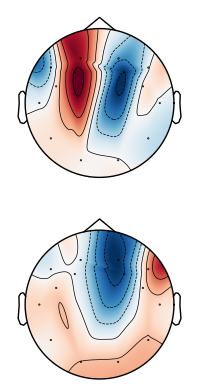

In [106]:
"""
Class activation topography (CAT) for EEG model visualization, combining class activity map and topography
Code: Class activation map (CAM) and then CAT

refer to high-star repo on github: 
https://github.com/WZMIAOMIAO/deep-learning-for-image-processing/tree/master/pytorch_classification/grad_cam

Salute every open-source researcher and developer!
"""

for nSub in range(1,24):

    # EDIT: Use ExGAN class to load train data
    exgan = ExGAN(nSub, 4)
    _, _, data, label = exgan.get_source_data(4)

    # ! A crucial step for adaptation on Transformer
    # reshape_transform  b 61 40 -> b 40 1 61
    def reshape_transform(tensor):
        result = rearrange(tensor, 'b (h w) e -> b e (h) (w)', h=1)
        return result
    
    device = torch.device("cuda")
    model = ViT().cuda()
    
    model.load_state_dict(torch.load('DASPS pth/model_subject%d.pth'%nSub, map_location=device))
    target_layers = [model[1]]  # set the target layer 
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True, reshape_transform=reshape_transform)
    
    # Define electrode names (Emotiv EPOC)
    ch_pos = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", 
          "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
    
    coords = 'coordinates.locs'
    
    # Create the custom montage
    montage = mne.channels.read_custom_montage(coords)
    
    info = mne.create_info(ch_names=montage.ch_names, sfreq=128.,
                            ch_types='eeg')
    
    
    all_cam = []
    # this loop is used to obtain the cam of each trial/sample
    for i in range(36):  # EDIT: change 35 for DASPS test trials
        test = torch.as_tensor(data[i:i+1, :, :, :], dtype=torch.float32)
        test = torch.autograd.Variable(test, requires_grad=True)
        
        grayscale_cam = cam(input_tensor=test)
         
        grayscale_cam = grayscale_cam[0, :]
        all_cam.append(grayscale_cam)
        
    
    # the mean of all data
    print("Pre-normalization mean:", np.mean(data))
    print("Pre-normalization std:", np.std(data))
    test_all_data = np.squeeze(np.mean(data, axis=0))
    test_all_data = (test_all_data - np.mean(test_all_data)) / np.std(test_all_data)
    mean_all_test = np.mean(test_all_data, axis=1)
    print("Post-normalization mean:", np.mean(test_all_data))
    print("Post-normalization std:", np.std(test_all_data))
    print("MEAN mean:", np.mean(mean_all_test))
    print("MEAN std:", np.std(mean_all_test))
    
    # the mean of all cam
    test_all_cam = np.mean(all_cam, axis=0)
    test_all_cam = (test_all_cam - np.mean(test_all_cam)) / np.std(test_all_cam)
    mean_all_cam = np.mean(test_all_cam, axis=1)
    
    # apply cam on the input data
    hyb_all = test_all_data * test_all_cam
    hyb_all = (hyb_all - np.mean(hyb_all)) / np.std(hyb_all)
    mean_hyb_all = np.mean(hyb_all, axis=1)
    
    #evoked = mne.EvokedArray(test_all_data, info)
    #evoked.set_montage(standard_montage)
    
    df=pd.DataFrame(test_all_data.T, columns=ch_pos) # It is important to the columns label is tally with the mont.ch_name
    evoked = mne.EvokedArray(df.to_numpy().T, info)
    evoked.set_montage(montage)
    
    fig, [ax1, ax2] = plt.subplots(nrows=2)
    
    # print(mean_all_test)
    # Raw data plot
    plt.subplot(211)
    im1, cn1 = mne.viz.plot_topomap(
        mean_all_test, 
        evoked.info, 
        show=False, 
        axes=ax1, 
        res=1200,
        sphere=0.12
    )
    
    # CAM plot
    plt.subplot(212)
    im2, cn2 = mne.viz.plot_topomap(
        mean_hyb_all, 
        evoked.info, 
        show=True, 
        axes=ax2, 
        res=1200, 
        sphere=0.12
    )

    # Save the figure for each subject
    fig.savefig(f"DASPS_sub_{nSub}_CAT_plots.png")
    plt.close(fig)
